In [1]:
# Loading libraries
import re
import ast
import time
import pandas as pd
from tqdm.auto import tqdm
from matplotlib import pyplot
from collections import Counter
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec

In [2]:
# Loading NLTK dataset
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Time calculation
def cal_elapsed_time(s):
    return print("Elapsed time:\t", round((time.time() - s),2))
s_time = time.time()
cal_elapsed_time(s=s_time)

Elapsed time:	 0.0


In [4]:
# Stop words like a,the, this, so etc
stop_words = set(stopwords.words('english'))

# Convert plural verb into sungular verb
lemmatizer = WordNetLemmatizer()
print("Length of stopwords: ", len(stop_words))
print("\nLemmatization")
print("rocks :", lemmatizer.lemmatize("rocks")) 

Length of stopwords:  179

Lemmatization
rocks : rock


# Data loading and cleaning

In [5]:
# Loading the dataset
data = pd.read_csv("movies_metadata.csv", low_memory=False)
df = data.copy()

# Separate Summary Data
mv = pd.DataFrame().assign(posts=df["overview"])
mv.dropna(inplace=True)
mv.drop_duplicates()

data_df = mv.copy()
data_df.head()

,posts
0,"Led by Woody, Andy's toys live happily in his ..."
1,When siblings Judy and Peter discover an encha...
2,A family wedding reignites the ancient feud be...
3,"Cheated on, mistreated and stepped on, the wom..."
4,Just when George Banks has recovered from his ...


## Data Statistics

In [6]:
df = data.copy()
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [7]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [8]:
df['adult'] = df['adult'].map({'True':True, 'False':False})

In [9]:
df['adult'].value_counts()

False    45454
True         9
Name: adult, dtype: int64

dict_values([1935, 13182, 2770, 3496, 2313, 6735, 20265, 6596, 4307, 7624, 4673, 1398, 3049, 2467, 1323, 1622, 1598, 3932, 1042, 767])

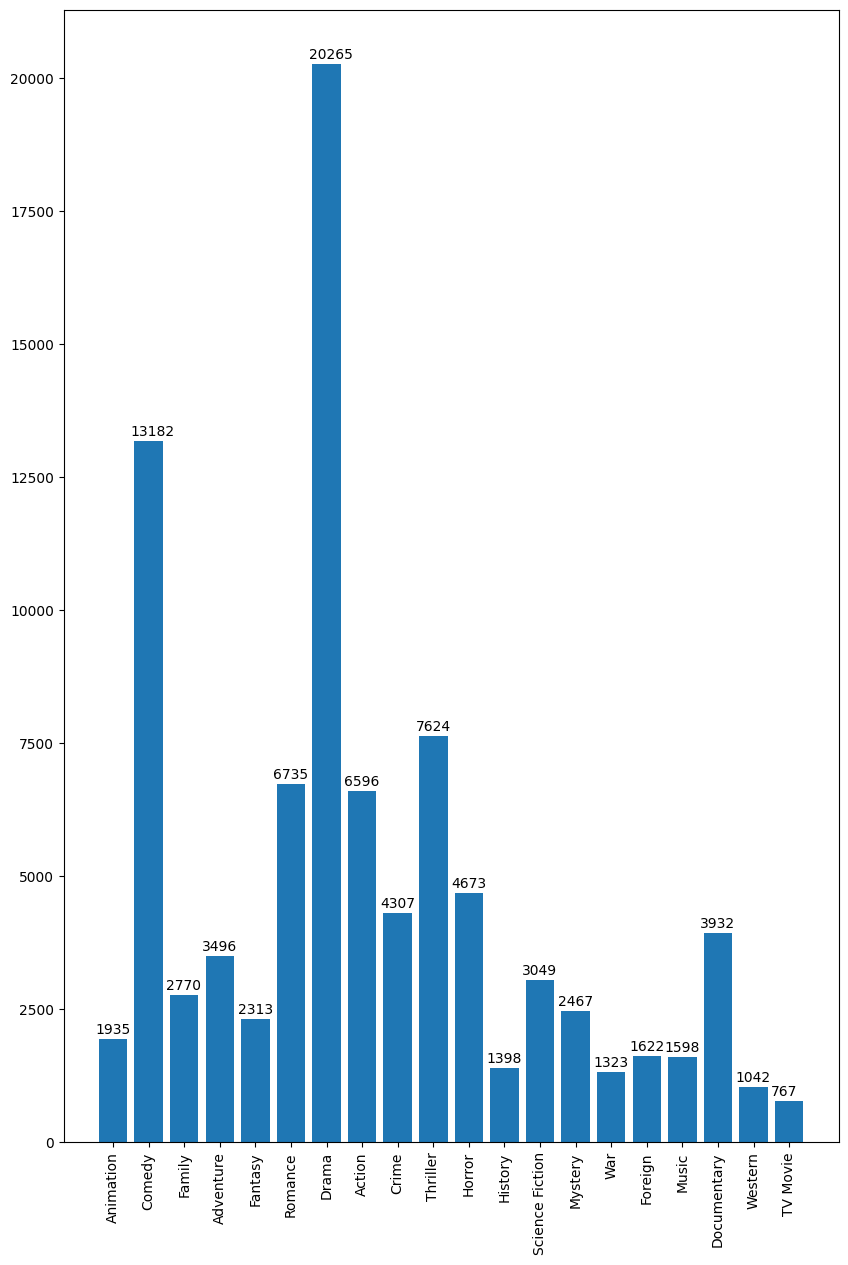

In [10]:
figure(figsize=(10, 15), dpi=100)
genre = []
for g in df['genres']:
    g = ast.literal_eval(g)
    for entry in g:
        genre.append(entry['name'])
count = Counter(genre)
count = {k: v for k, v in count.items() if v > 1}
pyplot.bar(range(len(count)), list(count.values()))
pyplot.xticks(range(len(count)), list(count.keys()), rotation=90)
for i, v in enumerate(count.values()):
    pyplot.text(i-0.5, v+100, str(v))
count.values()

In [11]:
df['vote_count'] = pd.to_numeric(df['vote_count'])

In [12]:
df['vote_average'] = pd.to_numeric(df['vote_average'])
max_rating = df[df['vote_count'] > 100]['vote_average'].max()
min_rating = df[df['vote_count'] > 100]['vote_average'].min()

In [13]:
df[(df['vote_average'] == max_rating) & (df['vote_count'] > 100)][['title', 'vote_average', 'vote_count']]

,title,vote_average,vote_count
10309,Dilwale Dulhania Le Jayenge,9.1,661.0


In [14]:
df[(df['vote_average'] == min_rating) & (df['vote_count'] > 100)][['title', 'vote_average', 'vote_count']]

,title,vote_average,vote_count
6723,House of the Dead,2.8,106.0


In [15]:
pd.to_numeric(df['popularity'], errors='coerce').corr(df['vote_average'])

0.15439944286409166

## Data for Model Training

In [16]:
# Removing na values from dataframe
def data_na_value_cleaning(data):
    print("\nBefore cleaning, Data Shape : ", data.shape)
    print("\nBefore removing Null values: ---------------")
    print(data.isna().sum())
    
    data.dropna(inplace=True)
    data.reset_index(inplace=True,drop=True)
    
    print("After removing Null values: ---------------")
    print(data.isna().sum())
    print("\nAfter cleaning, Data Shape : ", data.shape)
    
    return data


In [17]:
# Removing duplicate values
def duplicate_content_removal(data, col, ini_row):
    print("\nBefore removing duplicates, number of data was : ", ini_row)
    duplicate_count = data[col].duplicated().sum()
    print("\nNumber of Duplicates: ", duplicate_count)

    description_data = data[col].drop_duplicates()
    cleaned_row = len(description_data)
    
    if (ini_row - cleaned_row) > 0:
        print("\nTotal data reduction : ", (ini_row - cleaned_row))
        print("\nAfter removing duplicates, number of data is :", cleaned_row)
    else:
        print("\nDataset doesn't content any duplicate data.")
    
    return list(description_data)

In [18]:
data_df = data_na_value_cleaning(data_df)


Before cleaning, Data Shape :  (44512, 1)

Before removing Null values: ---------------
posts    0
dtype: int64
After removing Null values: ---------------
posts    0
dtype: int64

After cleaning, Data Shape :  (44512, 1)


In [19]:
posts = duplicate_content_removal(data_df, 'posts', data_df.shape[0])


Before removing duplicates, number of data was :  44512

Number of Duplicates:  205

Total data reduction :  205

After removing duplicates, number of data is : 44307


##### Data cleaning

In [20]:
def remove_link_punc(string):
    # removing links
    temp_string = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', string)

    # removing all everything except a-z english letters
    regex = re.compile('[^a-zA-Z]')
    temp_string = regex.sub(' ', temp_string)

    # removing extra spaces
    clean_string = re.sub(' +', ' ', temp_string).lower()    

    return clean_string


In [21]:
def data_cleaning(content):
    sentences = []
    for idx in tqdm(range(len(content))):
        
        if content[idx] !="":
            # Sentence tokenization using NLTK library
            for each_sent in  sent_tokenize(str(content[idx])):
                
                if each_sent != "":
                    temp_sent = []
                    # Removing link and punctuation
                    each_sent = remove_link_punc(each_sent.lower())

                    # Removing stopwords and applying lemmatization
                    for each_word in each_sent.split():
                        if each_word not in stop_words and len(each_word)>= 3:
                            temp_sent.append(lemmatizer.lemmatize(each_word))

                    # Only taking word list length is greater than equals to 5
                    if len(temp_sent) >= 5:
                        sentences.append(temp_sent)
    
    return sentences


In [22]:
sent_corpus = data_cleaning(posts)

  0%|          | 0/44307 [00:00<?, ?it/s]

In [23]:
# Sentence words stats
len_count = []
for l in sent_corpus:
    len_count.append(len(l))

print("Total number of Sentences : ", len(len_count))
word_sent_df = pd.DataFrame(sorted(Counter(len_count).items()), columns=["No of Words in each Sentence","No of sentence"])
word_sent_df.head(10)

Total number of Sentences :  109373


,No of Words in each Sentence,No of sentence
0,5,5087
1,6,6410
2,7,7847
3,8,8649
4,9,9139
5,10,9296
6,11,8865
7,12,8330
8,13,7532
9,14,6647


In [24]:
# data after cleaning and preprocessing
print(sent_corpus[0:100])

[['led', 'woody', 'andy', 'toy', 'live', 'happily', 'room', 'andy', 'birthday', 'brings', 'buzz', 'lightyear', 'onto', 'scene'], ['afraid', 'losing', 'place', 'andy', 'heart', 'woody', 'plot', 'buzz'], ['circumstance', 'separate', 'buzz', 'woody', 'owner', 'duo', 'eventually', 'learns', 'put', 'aside', 'difference'], ['sibling', 'judy', 'peter', 'discover', 'enchanted', 'board', 'game', 'open', 'door', 'magical', 'world', 'unwittingly', 'invite', 'alan', 'adult', 'trapped', 'inside', 'game', 'year', 'living', 'room'], ['alan', 'hope', 'freedom', 'finish', 'game', 'prof', 'risky', 'three', 'find', 'running', 'giant', 'rhinoceros', 'evil', 'monkey', 'terrifying', 'creature'], ['family', 'wedding', 'reignites', 'ancient', 'feud', 'next', 'door', 'neighbor', 'fishing', 'buddy', 'john', 'max'], ['meanwhile', 'sultry', 'italian', 'divorc', 'open', 'restaurant', 'local', 'bait', 'shop', 'alarming', 'local', 'worry', 'scare', 'fish', 'away'], ['le', 'interested', 'seafood', 'cooking', 'hot', '

## Model training

##### Using Gensim model to triain word2vec model

In [25]:
from gensim.models import Word2Vec

In [26]:
s_time = time.time()
print("Model Training Started...")
model = Word2Vec(sentences=sent_corpus, size=100, window=4, min_count=1, workers=4)
cal_elapsed_time(s_time)

Model Training Started...
Elapsed time:	 21.15


In [27]:
print("Total number of unique words loaded in Model : ", len(model.wv.vocab))

Total number of unique words loaded in Model :  66112


In [28]:
model.wv.vocab

{'led': <gensim.models.keyedvectors.Vocab at 0x7f890447b8b0>,
 'woody': <gensim.models.keyedvectors.Vocab at 0x7f890447beb0>,
 'andy': <gensim.models.keyedvectors.Vocab at 0x7f890447bf10>,
 'toy': <gensim.models.keyedvectors.Vocab at 0x7f890447be20>,
 'live': <gensim.models.keyedvectors.Vocab at 0x7f8903665160>,
 'happily': <gensim.models.keyedvectors.Vocab at 0x7f89036650d0>,
 'room': <gensim.models.keyedvectors.Vocab at 0x7f8903665310>,
 'birthday': <gensim.models.keyedvectors.Vocab at 0x7f8903665670>,
 'brings': <gensim.models.keyedvectors.Vocab at 0x7f8903665280>,
 'buzz': <gensim.models.keyedvectors.Vocab at 0x7f89036655b0>,
 'lightyear': <gensim.models.keyedvectors.Vocab at 0x7f8903665520>,
 'onto': <gensim.models.keyedvectors.Vocab at 0x7f8903665430>,
 'scene': <gensim.models.keyedvectors.Vocab at 0x7f8903665400>,
 'afraid': <gensim.models.keyedvectors.Vocab at 0x7f89036655e0>,
 'losing': <gensim.models.keyedvectors.Vocab at 0x7f8903665070>,
 'place': <gensim.models.keyedvectors

In [29]:
# Saving the model
model.save("trainned_model.model")

In [30]:
# Loading the model
model = Word2Vec.load("trainned_model.model")

In [31]:
# Find similar words for efficiency
model.wv.most_similar("family", topn=10)

[('mcginley', 0.7466999888420105),
 ('relative', 0.7361434698104858),
 ('childhood', 0.7203693389892578),
 ('aydin', 0.7175112962722778),
 ('foy', 0.71738600730896),
 ('instanbul', 0.7082829475402832),
 ('economical', 0.6980666518211365),
 ('existence', 0.6969224214553833),
 ('parent', 0.6962380409240723),
 ('phaen', 0.6951918005943298)]

##### Related/Similar words visualization

In [32]:
word_list = []
for w, s in model.wv.most_similar("family", topn=10):
    word_list.append(w)
word_list.append('family')
word_list

['mcginley',
 'relative',
 'childhood',
 'aydin',
 'foy',
 'instanbul',
 'economical',
 'existence',
 'parent',
 'phaen',
 'family']

In [33]:
words = {w:model.wv.vocab[w] for w in word_list}
words

{'mcginley': <gensim.models.keyedvectors.Vocab at 0x7f88f9011d30>,
 'relative': <gensim.models.keyedvectors.Vocab at 0x7f88f9fc2730>,
 'childhood': <gensim.models.keyedvectors.Vocab at 0x7f88f9fa1af0>,
 'aydin': <gensim.models.keyedvectors.Vocab at 0x7f88f8897400>,
 'foy': <gensim.models.keyedvectors.Vocab at 0x7f88f9309ee0>,
 'instanbul': <gensim.models.keyedvectors.Vocab at 0x7f88f99151c0>,
 'economical': <gensim.models.keyedvectors.Vocab at 0x7f88f92cbac0>,
 'existence': <gensim.models.keyedvectors.Vocab at 0x7f88f9c63c10>,
 'parent': <gensim.models.keyedvectors.Vocab at 0x7f88f9ed8a90>,
 'phaen': <gensim.models.keyedvectors.Vocab at 0x7f88f8c83280>,
 'family': <gensim.models.keyedvectors.Vocab at 0x7f88fbff1ee0>}

In [34]:
X = model[words]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

<ipython-input-34-7fecf15bedc1>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[words]


In [35]:
X

array([[-0.01340108,  0.01268085,  0.01344511, ...,  0.00779837,
         0.01376356,  0.00567934],
       [-0.20403853,  0.29840705,  0.5474229 , ..., -0.49201402,
         0.22533716,  0.22686127],
       [-0.2049771 ,  0.32278025,  1.2943685 , ..., -0.2343217 ,
         1.1329588 ,  0.14798462],
       ...,
       [-0.53161925,  0.20544583,  0.9490685 , ..., -1.5508633 ,
         0.68709606,  0.9990769 ],
       [-0.03423778,  0.02143932,  0.02321688, ..., -0.01746841,
         0.0170083 ,  0.02213172],
       [-1.5981271 ,  0.93437904,  2.0707104 , ..., -0.44475845,
         0.35124242,  0.00967196]], dtype=float32)

In [36]:
result

array([[-2.7600083 ,  0.17351799],
       [ 0.85189617, -0.5418986 ],
       [ 3.7228758 , -1.1981524 ],
       [-2.6947973 ,  0.17516573],
       [-2.7781491 ,  0.15162611],
       [-2.7462642 ,  0.15564144],
       [-2.65243   ,  0.13326026],
       [ 1.0246215 ,  0.19101271],
       [ 4.778354  , -3.0891476 ],
       [-2.6399853 ,  0.12242983],
       [ 5.893887  ,  3.7265449 ]], dtype=float32)

In [37]:
x_values = [ x[0] for x in result ]
x_values

[-2.7600083,
 0.85189617,
 3.7228758,
 -2.6947973,
 -2.7781491,
 -2.7462642,
 -2.65243,
 1.0246215,
 4.778354,
 -2.6399853,
 5.893887]

In [38]:
y_values = [ y[1] for y in result ]
y_values

[0.17351799,
 -0.5418986,
 -1.1981524,
 0.17516573,
 0.15162611,
 0.15564144,
 0.13326026,
 0.19101271,
 -3.0891476,
 0.12242983,
 3.7265449]

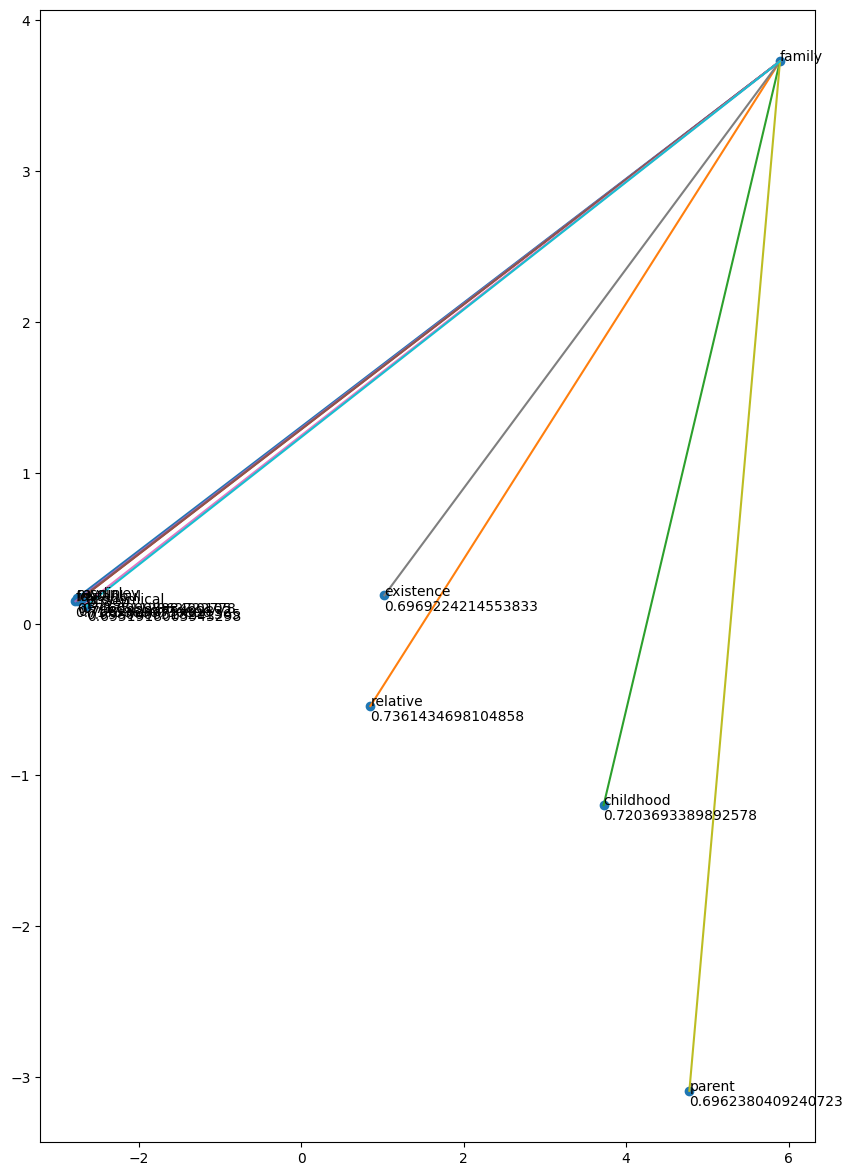

In [39]:
figure(figsize=(10, 15), dpi=100)

fam_x = x_values[-1]
fam_y = y_values[-1]
pyplot.scatter(result[:, 0], result[:, 1])
for i in range(len(x_values[:-1])):
    pyplot.plot([fam_x, x_values[i]], [fam_y, y_values[i]])
    pyplot.text(x_values[i], y_values[i]-0.1, model.wv.most_similar("family", topn=10)[i][1])
for i, word in enumerate(word_list):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()